# Data 경로 설정
- 데이터 경로 설정

In [538]:
TEST_DATA_PATH = '../data/origin/test/'
TRAIN_DATA_PATH = '../data/origin/train/'

# instead of weather_station_to_county_mapping.csv, use fabiendaniels-mapping-locations-and-county-codes
# https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
county_mapper = '../data/origin/county_lon_lats.csv'

test_csv = f'{TEST_DATA_PATH}test.csv'
test_client_csv = f'{TEST_DATA_PATH}client.csv'
test_electricity_prices_csv = f'{TEST_DATA_PATH}electricity_prices.csv'
test_forecast_weather_csv = f'{TEST_DATA_PATH}forecast_weather.csv'
test_gas_prices_csv = f'{TEST_DATA_PATH}gas_prices.csv'
test_historical_weather_csv = f'{TEST_DATA_PATH}historical_weather.csv'
# test_weather_station_to_county_mapping_csv = f'{TEST_DATA_PATH}weather_station_to_county_mapping.csv'
# test_county_id_to_name_map_json = f'{TEST_DATA_PATH}county_id_to_name_map.json'

train_csv = f'{TRAIN_DATA_PATH}train.csv'
train_client_csv = f'{TRAIN_DATA_PATH}client.csv'
train_electricity_prices_csv = f'{TRAIN_DATA_PATH}electricity_prices.csv'
train_forecast_weather_csv = f'{TRAIN_DATA_PATH}forecast_weather.csv'
train_gas_prices_csv = f'{TRAIN_DATA_PATH}gas_prices.csv'
train_historical_weather_csv = f'{TRAIN_DATA_PATH}historical_weather.csv'
# train_weather_station_to_county_mapping_csv = f'{TRAIN_DATA_PATH}weather_station_to_county_mapping.csv'
# train_county_id_to_name_map_json = f'{TRAIN_DATA_PATH}county_id_to_name_map.json'

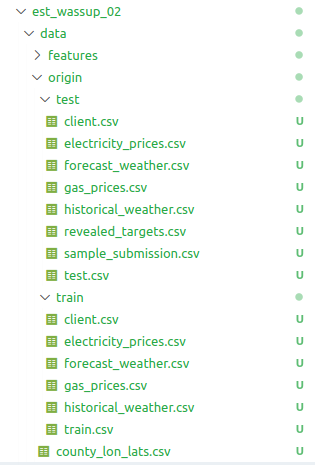

In [539]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Train csv 머지
- 아래의 파일들을 Train csv 로 머지 합니다.
  - client
  - electricity_prices
  - forecast_weather
  - gas_prices
  - historical_weather
  - weather_station_to_county_mapping
  - county_id_to_name_map

In [540]:
df_train = pd.read_csv(train_csv)
df_train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


### datetime 변경
- str to datetime

In [541]:
df_train['datetime'] = pd.to_datetime(df_train.datetime)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 138.6 MB


In [542]:
df_train[df_train.data_block_id == 1]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
2928,0,0,1,1.687,0,2021-09-02 00:00:00,1,2928,0
2929,0,0,1,109.366,1,2021-09-02 00:00:00,1,2929,0
2930,0,0,2,0.000,0,2021-09-02 00:00:00,1,2930,1
2931,0,0,2,21.008,1,2021-09-02 00:00:00,1,2931,1
2932,0,0,3,1.003,0,2021-09-02 00:00:00,1,2932,2
...,...,...,...,...,...,...,...,...,...
5851,15,0,3,59.302,1,2021-09-02 23:00:00,1,5851,58
5852,15,1,1,0.000,0,2021-09-02 23:00:00,1,5852,59
5853,15,1,1,21.756,1,2021-09-02 23:00:00,1,5853,59
5854,15,1,3,0.000,0,2021-09-02 23:00:00,1,5854,60


## 머지 1
- Eletricity prices & Gas prices
- **data block id 에 맞춰 머지**합니다.
  - 추후 origin_date 와 forecast_date 에 대한 정보를 다시한번 확인해야 할 필요가 있습니다.
  - 두 컬럼의 차이
  - **우선은 data_block_id 가 0 인 경우엔 NaN 값 들어갑니다.**
### 결과 추가된 컬럼명
- elec_price
- highest_gas_price
- lowest_gas_price
- mean_gas_price
  - hightest_price 와 lowest_prices 의 평균값 사용
- forecast_date_gas / forecast_date_elec
- origin_date_gas / origin_date_elec

### Electricity

In [501]:
df_elec = pd.read_csv(train_electricity_prices_csv)
df_elec.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [502]:
df_elec['datetime'] = pd.to_datetime(df_elec.forecast_date) + pd.DateOffset(1)
df_elec.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id,datetime
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1,2021-09-02 00:00:00
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1,2021-09-02 01:00:00
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1,2021-09-02 02:00:00
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1,2021-09-02 03:00:00
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1,2021-09-02 04:00:00


In [503]:
df_elec.rename(columns={'forecast_date': 'forecast_date_elec', 'origin_date': 'origin_date_elec', 'euros_per_mwh': 'elec_price'}, inplace=True)
df_elec

,forecast_date_elec,elec_price,origin_date_elec,data_block_id,datetime
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1,2021-09-02 00:00:00
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1,2021-09-02 01:00:00
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1,2021-09-02 02:00:00
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1,2021-09-02 03:00:00
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1,2021-09-02 04:00:00
...,...,...,...,...,...
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637,2023-05-31 19:00:00
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637,2023-05-31 20:00:00
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637,2023-05-31 21:00:00
15284,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637,2023-05-31 22:00:00


In [504]:
df_train = df_train.merge(df_elec, how='left', on=['datetime', 'data_block_id'])
df_train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,forecast_date_elec,elec_price,origin_date_elec
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00


### Gas

In [505]:
df_gas = pd.read_csv(train_gas_prices_csv)
df_gas.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [506]:
df_gas['mean_gas_price'] = (df_gas.lowest_price_per_mwh + df_gas.highest_price_per_mwh) / 2
df_gas.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,mean_gas_price
0,2021-09-01,45.23,46.32,2021-08-31,1,45.775
1,2021-09-02,45.62,46.29,2021-09-01,2,45.955
2,2021-09-03,45.85,46.40,2021-09-02,3,46.125
3,2021-09-04,46.30,46.80,2021-09-03,4,46.550
4,2021-09-05,46.30,46.58,2021-09-04,5,46.440


In [507]:
df_gas.rename(columns={
  'lowest_price_per_mwh': 'lowest_gas_price',
  'highest_price_per_mwh':'highest_gas_price',
  'forecast_date': 'forecast_date_gas',
  'origin_date': 'origin_date_gas'
  }, inplace=True)

In [508]:
df_gas.head()

,forecast_date_gas,lowest_gas_price,highest_gas_price,origin_date_gas,data_block_id,mean_gas_price
0,2021-09-01,45.23,46.32,2021-08-31,1,45.775
1,2021-09-02,45.62,46.29,2021-09-01,2,45.955
2,2021-09-03,45.85,46.40,2021-09-02,3,46.125
3,2021-09-04,46.30,46.80,2021-09-03,4,46.550
4,2021-09-05,46.30,46.58,2021-09-04,5,46.440


In [509]:
df_train = df_train.merge(df_gas, how='left', on='data_block_id')
df_train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,forecast_date_elec,elec_price,origin_date_elec,forecast_date_gas,lowest_gas_price,highest_gas_price,origin_date_gas,mean_gas_price
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5


## 머지 2
- client
### 추가 컬럼
- eic_count
- installed_capacity

In [510]:
df_client = pd.read_csv(train_client_csv)
df_client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [511]:
df_client.isna().sum()

product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
date                  0
data_block_id         0
dtype: int64

In [512]:
df_train = df_train.merge(df_client.drop(columns=['date']), how='left', on=['product_type', 'county', 'is_business', 'data_block_id'])
df_train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,forecast_date_elec,elec_price,origin_date_elec,forecast_date_gas,lowest_gas_price,highest_gas_price,origin_date_gas,mean_gas_price,eic_count,installed_capacity
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,15.0,620.0
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,20.0,624.5
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,20.0,624.5
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,55.0,2188.2


## 머지 3
- Forecast weather & historical weather
- weather data 를 county_mapper 를 활용하여 매핑하여 county 를 추가합니다.
### 결과 추가된 컬럼명
- elec_price
- gas_price
  - hightest_price 와 lowest_prices 의 평균값 사용

In [513]:
df_county_mapper = pd.read_csv(county_mapper, index_col=0)
df_county_mapper.head()

,county,longitude,latitude
0,0,24.2,59.1
1,0,25.2,59.1
2,0,23.7,59.4
3,0,24.2,59.4
4,0,24.7,59.4


In [514]:
for k in ['latitude', 'longitude'] :
    df_county_mapper[k] = df_county_mapper[k].astype(float).round(1)
df_county_mapper.head()

,county,longitude,latitude
0,0,24.2,59.1
1,0,25.2,59.1
2,0,23.7,59.4
3,0,24.2,59.4
4,0,24.7,59.4


### historical weather

In [515]:
df_h_weather = pd.read_csv(train_historical_weather_csv)
df_h_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [516]:
df_h_weather['datetime'] = pd.to_datetime(df_h_weather['datetime'])
df_h_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [517]:
for k in ['latitude', 'longitude'] :
        df_h_weather[k] = df_h_weather[k].astype(float).round(1)
df_h_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [518]:
df_h_weather = df_h_weather.merge(df_county_mapper, how='left', on=['latitude', 'longitude'])
df_h_weather.county = df_h_weather.county.fillna(-1).astype(float)
df_h_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,county
0,2021-09-01,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0,-1.0
1,2021-09-01,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0,-1.0
2,2021-09-01,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0,-1.0
3,2021-09-01,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0,10.0
4,2021-09-01,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0,-1.0


In [519]:
sorted(df_h_weather.county.unique())

[-1.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 13.0,
 14.0,
 15.0]

In [520]:
agg_columns = [col for col in df_h_weather.columns if col not in ['longitude', 'latitude', 'datetime', 'county', 'data_block_id']]
agg_dict = {agg_col: ['mean'] for agg_col in agg_columns}
df_h_weather = df_h_weather.groupby(['datetime', 'county', 'data_block_id']).agg(agg_dict).reset_index() 

def flatten_multi_index_columns(df):
  df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                for multi_col in df.columns]
  return df

# Flatten the multi column aggregates
df_h_weather = flatten_multi_index_columns(df_h_weather) 

# Test set has 1 day offset for hour<11 and 2 day offset for hour>11
df_h_weather['hour_h'] = df_h_weather['datetime'].dt.hour
df_h_weather['datetime'] = (
  df_h_weather
  .apply(lambda x: 
        x['datetime'] + pd.DateOffset(1) 
        if x['hour_h']< 11 
        else x['datetime'] + pd.DateOffset(2),
        axis=1)
)
df_h_weather.head()

,datetime,county,data_block_id,temperature_mean,dewpoint_mean,rain_mean,snowfall_mean,surface_pressure_mean,cloudcover_total_mean,cloudcover_low_mean,cloudcover_mid_mean,cloudcover_high_mean,windspeed_10m_mean,winddirection_10m_mean,shortwave_radiation_mean,direct_solar_radiation_mean,diffuse_radiation_mean,hour_h
0,2021-09-02,-1.0,1.0,13.713514,11.386486,0.037838,0.0,1009.962162,42.837838,34.594595,7.594595,40.810811,5.390390,315.540541,9.432432,7.405405,2.027027,0
1,2021-09-02,0.0,1.0,13.790000,10.730000,0.000000,0.0,1010.560000,54.400000,56.900000,3.500000,3.900000,5.325000,342.000000,0.000000,0.000000,0.000000,0
2,2021-09-02,1.0,1.0,13.733333,10.816667,0.000000,0.0,1015.700000,24.500000,9.666667,0.000000,52.666667,7.620370,354.833333,0.000000,0.000000,0.000000,0
3,2021-09-02,2.0,1.0,12.000000,10.725000,0.000000,0.0,1006.150000,50.750000,49.250000,3.500000,13.750000,2.888889,317.250000,0.000000,0.000000,0.000000,0
4,2021-09-02,3.0,1.0,11.533333,9.733333,0.000000,0.0,1004.133333,84.666667,90.666667,5.333333,0.000000,2.379630,314.333333,0.000000,0.000000,0.000000,0


In [521]:
df_h_weather.hour_h.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int32)

In [522]:
df_h_weather['datetime'].dt.time.unique()

array([datetime.time(0, 0), datetime.time(1, 0), datetime.time(2, 0),
       datetime.time(3, 0), datetime.time(4, 0), datetime.time(5, 0),
       datetime.time(6, 0), datetime.time(7, 0), datetime.time(8, 0),
       datetime.time(9, 0), datetime.time(10, 0), datetime.time(11, 0),
       datetime.time(12, 0), datetime.time(13, 0), datetime.time(14, 0),
       datetime.time(15, 0), datetime.time(16, 0), datetime.time(17, 0),
       datetime.time(18, 0), datetime.time(19, 0), datetime.time(20, 0),
       datetime.time(21, 0), datetime.time(22, 0), datetime.time(23, 0)],
      dtype=object)

In [523]:
df_train = df_train.merge(df_h_weather, how='left', on=['datetime', 'county', 'data_block_id'])
df_train[df_train.data_block_id == 2]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,forecast_date_elec,...,cloudcover_total_mean,cloudcover_low_mean,cloudcover_mid_mean,cloudcover_high_mean,windspeed_10m_mean,winddirection_10m_mean,shortwave_radiation_mean,direct_solar_radiation_mean,diffuse_radiation_mean,hour_h
5856,0,0,1,0.793,0,2021-09-03 00:00:00,2,5856,0,2021-09-02 00:00:00,...,51.0,27.9,43.0,0.0,6.350000,346.7,0.0,0.0,0.0,0.0
5857,0,0,1,107.129,1,2021-09-03 00:00:00,2,5857,0,2021-09-02 00:00:00,...,51.0,27.9,43.0,0.0,6.350000,346.7,0.0,0.0,0.0,0.0
5858,0,0,2,0.000,0,2021-09-03 00:00:00,2,5858,1,2021-09-02 00:00:00,...,51.0,27.9,43.0,0.0,6.350000,346.7,0.0,0.0,0.0,0.0
5859,0,0,2,19.630,1,2021-09-03 00:00:00,2,5859,1,2021-09-02 00:00:00,...,51.0,27.9,43.0,0.0,6.350000,346.7,0.0,0.0,0.0,0.0
5860,0,0,3,0.977,0,2021-09-03 00:00:00,2,5860,2,2021-09-02 00:00:00,...,51.0,27.9,43.0,0.0,6.350000,346.7,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,15,0,3,71.039,1,2021-09-03 23:00:00,2,8779,58,2021-09-02 23:00:00,...,50.2,27.4,42.6,0.0,4.288889,322.4,0.0,0.0,0.0,23.0
8780,15,1,1,0.100,0,2021-09-03 23:00:00,2,8780,59,2021-09-02 23:00:00,...,50.2,27.4,42.6,0.0,4.288889,322.4,0.0,0.0,0.0,23.0
8781,15,1,1,24.501,1,2021-09-03 23:00:00,2,8781,59,2021-09-02 23:00:00,...,50.2,27.4,42.6,0.0,4.288889,322.4,0.0,0.0,0.0,23.0
8782,15,1,3,0.000,0,2021-09-03 23:00:00,2,8782,60,2021-09-02 23:00:00,...,50.2,27.4,42.6,0.0,4.288889,322.4,0.0,0.0,0.0,23.0


### Forecast Weather

In [524]:
df_f_weather = pd.read_csv(train_forecast_weather_csv)
df_f_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [525]:
# Rename column and drop
df_f_weather = (
  df_f_weather
  .rename(columns={'forecast_datetime': 'datetime'})
  .drop(columns='origin_datetime') # not needed
  )

# To datetime
df_f_weather['datetime'] = (
  pd.to_datetime(df_f_weather['datetime'])
  .dt
  .tz_localize(None)
  )

# Add county
df_f_weather[['latitude', 'longitude']] = df_f_weather[['latitude', 'longitude']].astype(float).round(1)

df_f_weather = df_f_weather.merge(df_county_mapper, how='left', on=['latitude', 'longitude'])

df_f_weather

,latitude,longitude,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
0,57.6,21.7,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
1,57.6,22.2,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
2,57.6,22.7,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
3,57.6,23.2,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10.0
4,57.6,23.7,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,5.0
3424508,59.7,26.7,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,5.0
3424509,59.7,27.2,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,NaN
3424510,59.7,27.7,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,NaN


In [526]:
def create_new_column_names(df, suffix, columns_no_change):
  '''Change column names by given suffix, keep columns_no_change, and return back the data'''
  df.columns = [
    col + suffix 
    if col not in columns_no_change
    else col
    for col in df.columns
  ]
  return df 

In [527]:
# Modify column names - specify suffix
df_f_weather = create_new_column_names(
  df_f_weather,
  suffix='_f',
  columns_no_change=['latitude', 'longitude', 'datetime', 'county', 'data_block_id']
  ) 

df_f_weather.head()

,latitude,longitude,hours_ahead_f,temperature_f,dewpoint_f,cloudcover_high_f,cloudcover_low_f,cloudcover_mid_f,cloudcover_total_f,10_metre_u_wind_component_f,10_metre_v_wind_component_f,data_block_id,datetime,direct_solar_radiation_f,surface_solar_radiation_downwards_f,snowfall_f,total_precipitation_f,county
0,57.6,21.7,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
1,57.6,22.2,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
2,57.6,22.7,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
3,57.6,23.2,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10.0
4,57.6,23.7,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN


In [528]:
# Group by & calculate aggregate stats 
agg_columns = [col for col in df_f_weather.columns if col not in ['latitude', 'longitude', 'datetime', 'county', 'data_block_id']]
agg_dict = {agg_col: ['mean'] for agg_col in agg_columns}
df_f_weather = df_f_weather.groupby(['datetime', 'county', 'data_block_id']).agg(agg_dict).reset_index() 
df_f_weather

,datetime,county,data_block_id,hours_ahead_f,temperature_f,dewpoint_f,cloudcover_high_f,cloudcover_low_f,cloudcover_mid_f,cloudcover_total_f,10_metre_u_wind_component_f,10_metre_v_wind_component_f,direct_solar_radiation_f,surface_solar_radiation_downwards_f,snowfall_f,total_precipitation_f
,,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2021-09-01 03:00:00,0.0,1,1.0,13.279187,10.265674,0.192630,0.036087,0.005286,0.215636,2.511035,-5.096591,0.0,0.0,0.0,0.0
1,2021-09-01 03:00:00,1.0,1,1.0,15.116134,12.090133,0.430842,0.082311,0.001534,0.472204,2.644783,-8.267026,0.0,0.0,0.0,0.0
2,2021-09-01 03:00:00,2.0,1,1.0,12.474969,10.658960,0.110397,0.232323,0.242676,0.375809,2.035235,-3.794675,0.0,0.0,0.0,0.0
3,2021-09-01 03:00:00,3.0,1,1.0,12.619938,9.741927,0.424205,0.634064,0.080317,0.818268,1.503467,-4.013771,0.0,0.0,0.0,0.0
4,2021-09-01 03:00:00,4.0,1,1.0,11.647485,9.851007,0.073845,0.346710,0.114063,0.382408,2.643085,-3.504880,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458575,2023-06-01 02:00:00,10.0,637,48.0,10.615127,6.470626,0.024872,0.009333,0.003970,0.035352,2.902894,-3.063768,0.0,0.0,0.0,0.0
458576,2023-06-01 02:00:00,11.0,637,48.0,9.262720,4.605676,0.475815,0.003971,0.000000,0.479546,4.452760,-1.488644,0.0,0.0,0.0,0.0
458577,2023-06-01 02:00:00,13.0,637,48.0,8.815088,3.881494,0.723846,0.000000,0.000000,0.723846,3.747071,-1.961269,0.0,0.0,0.0,0.0


In [529]:
# Flatten the multi column aggregates
df_f_weather = flatten_multi_index_columns(df_f_weather)
df_f_weather.head()

,datetime,county,data_block_id,hours_ahead_f_mean,temperature_f_mean,dewpoint_f_mean,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean
0,2021-09-01 03:00:00,0.0,1,1.0,13.279187,10.265674,0.192630,0.036087,0.005286,0.215636,2.511035,-5.096591,0.0,0.0,0.0,0.0
1,2021-09-01 03:00:00,1.0,1,1.0,15.116134,12.090133,0.430842,0.082311,0.001534,0.472204,2.644783,-8.267026,0.0,0.0,0.0,0.0
2,2021-09-01 03:00:00,2.0,1,1.0,12.474969,10.658960,0.110397,0.232323,0.242676,0.375809,2.035235,-3.794675,0.0,0.0,0.0,0.0
3,2021-09-01 03:00:00,3.0,1,1.0,12.619938,9.741927,0.424205,0.634064,0.080317,0.818268,1.503467,-4.013771,0.0,0.0,0.0,0.0
4,2021-09-01 03:00:00,4.0,1,1.0,11.647485,9.851007,0.073845,0.346710,0.114063,0.382408,2.643085,-3.504880,0.0,0.0,0.0,0.0


In [530]:
df_train = df_train.merge(df_f_weather, how='left', on=['datetime', 'county', 'data_block_id'])
df_train[df_train.data_block_id == 2]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,forecast_date_elec,...,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean
5856,0,0,1,0.793,0,2021-09-03 00:00:00,2,5856,0,2021-09-02 00:00:00,...,0.53911,0.240854,0.748516,0.879295,8.725091,-3.811827,0.0,0.0,0.0,9.370089e-05
5857,0,0,1,107.129,1,2021-09-03 00:00:00,2,5857,0,2021-09-02 00:00:00,...,0.53911,0.240854,0.748516,0.879295,8.725091,-3.811827,0.0,0.0,0.0,9.370089e-05
5858,0,0,2,0.000,0,2021-09-03 00:00:00,2,5858,1,2021-09-02 00:00:00,...,0.53911,0.240854,0.748516,0.879295,8.725091,-3.811827,0.0,0.0,0.0,9.370089e-05
5859,0,0,2,19.630,1,2021-09-03 00:00:00,2,5859,1,2021-09-02 00:00:00,...,0.53911,0.240854,0.748516,0.879295,8.725091,-3.811827,0.0,0.0,0.0,9.370089e-05
5860,0,0,3,0.977,0,2021-09-03 00:00:00,2,5860,2,2021-09-02 00:00:00,...,0.53911,0.240854,0.748516,0.879295,8.725091,-3.811827,0.0,0.0,0.0,9.370089e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,15,0,3,71.039,1,2021-09-03 23:00:00,2,8779,58,2021-09-02 23:00:00,...,0.00000,0.109555,0.082193,0.130826,2.990293,-2.146681,0.0,0.0,0.0,-4.111789e-08
8780,15,1,1,0.100,0,2021-09-03 23:00:00,2,8780,59,2021-09-02 23:00:00,...,0.00000,0.109555,0.082193,0.130826,2.990293,-2.146681,0.0,0.0,0.0,-4.111789e-08
8781,15,1,1,24.501,1,2021-09-03 23:00:00,2,8781,59,2021-09-02 23:00:00,...,0.00000,0.109555,0.082193,0.130826,2.990293,-2.146681,0.0,0.0,0.0,-4.111789e-08
8782,15,1,3,0.000,0,2021-09-03 23:00:00,2,8782,60,2021-09-02 23:00:00,...,0.00000,0.109555,0.082193,0.130826,2.990293,-2.146681,0.0,0.0,0.0,-4.111789e-08


# 최종 머지한 데이터

In [531]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 47 columns):
 #   Column                                    Dtype         
---  ------                                    -----         
 0   county                                    int64         
 1   is_business                               int64         
 2   product_type                              int64         
 3   target                                    float64       
 4   is_consumption                            int64         
 5   datetime                                  datetime64[ns]
 6   data_block_id                             int64         
 7   row_id                                    int64         
 8   prediction_unit_id                        int64         
 9   forecast_date_elec                        object        
 10  elec_price                                float64       
 11  origin_date_elec                          object        
 12  forecast_date_

In [532]:
df_train.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id',
       'forecast_date_elec', 'elec_price', 'origin_date_elec',
       'forecast_date_gas', 'lowest_gas_price', 'highest_gas_price',
       'origin_date_gas', 'mean_gas_price', 'eic_count', 'installed_capacity',
       'temperature_mean', 'dewpoint_mean', 'rain_mean', 'snowfall_mean',
       'surface_pressure_mean', 'cloudcover_total_mean', 'cloudcover_low_mean',
       'cloudcover_mid_mean', 'cloudcover_high_mean', 'windspeed_10m_mean',
       'winddirection_10m_mean', 'shortwave_radiation_mean',
       'direct_solar_radiation_mean', 'diffuse_radiation_mean', 'hour_h',
       'hours_ahead_f_mean', 'temperature_f_mean', 'dewpoint_f_mean',
       'cloudcover_high_f_mean', 'cloudcover_low_f_mean',
       'cloudcover_mid_f_mean', 'cloudcover_total_f_mean',
       '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean',
       'direct

In [533]:
df_train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,forecast_date_elec,...,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-30 23:00:00,...,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-30 23:00:00,...,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-30 23:00:00,...,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-30 23:00:00,...,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0


# csv 로 저장

In [534]:
df_train.to_csv('../data/features/train.csv')

# Test csv 머지
- 아래의 파일들을 Train csv 로 머지 합니다.
  - client
  - electricity_prices
  - forecast_weather
  - gas_prices
  - historical_weather
  - weather_station_to_county_mapping
  - county_id_to_name_map

In [535]:
df_test = pd.read_csv(test_csv)
df_test.head()

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False


In [536]:
df_test.rename(columns={'prediction_datetime': 'datetime'}, inplace=True)
df_test['datetime'] = pd.to_datetime(df_test.datetime)


# elec merge
df_elec_test = pd.read_csv(test_electricity_prices_csv)
df_elec_test['datetime'] = pd.to_datetime(df_elec_test.forecast_date) + pd.DateOffset(1)
df_elec_test.rename(columns={'forecast_date': 'forecast_date_elec', 'origin_date': 'origin_date_elec', 'euros_per_mwh': 'elec_price'}, inplace=True)
df_test = df_test.merge(df_elec_test, how='left', on=['datetime', 'data_block_id'])


# gas merge
df_gas_test = pd.read_csv(test_gas_prices_csv)
df_gas_test['mean_gas_price'] = (df_gas_test.lowest_price_per_mwh + df_gas_test.highest_price_per_mwh) / 2
df_gas_test.rename(columns={
  'lowest_price_per_mwh': 'lowest_gas_price',
  'highest_price_per_mwh':'highest_gas_price',
  'forecast_date': 'forecast_date_gas',
  'origin_date': 'origin_date_gas'
  }, inplace=True)
df_test = df_test.merge(df_gas_test, how='left', on='data_block_id')

# client merge
df_client_test = pd.read_csv(test_client_csv)
df_test = df_test.merge(df_client_test.drop(columns=['date']), how='left', on=['product_type', 'county', 'is_business', 'data_block_id'])


# historical weather merge
df_h_weather_test = pd.read_csv(test_historical_weather_csv)
df_h_weather_test['datetime'] = pd.to_datetime(df_h_weather_test['datetime'])
for k in ['latitude', 'longitude'] :
        df_h_weather_test[k] = df_h_weather_test[k].astype(float).round(1)
df_h_weather_test = df_h_weather_test.merge(df_county_mapper, how='left', on=['latitude', 'longitude'])
df_h_weather_test.county = df_h_weather_test.county.fillna(-1).astype(float)
agg_columns = [col for col in df_h_weather_test.columns if col not in ['longitude', 'latitude', 'datetime', 'county', 'data_block_id']]
agg_dict = {agg_col: ['mean'] for agg_col in agg_columns}
df_h_weather_test = df_h_weather_test.groupby(['datetime', 'county', 'data_block_id']).agg(agg_dict).reset_index() 

# Flatten the multi column aggregates
df_h_weather_test = flatten_multi_index_columns(df_h_weather_test) 

# Test set has 1 day offset for hour<11 and 2 day offset for hour>11
df_h_weather_test['hour_h'] = df_h_weather_test['datetime'].dt.hour
df_h_weather_test['datetime'] = (
  df_h_weather_test
  .apply(lambda x: 
        x['datetime'] + pd.DateOffset(1) 
        if x['hour_h']< 11 
        else x['datetime'] + pd.DateOffset(2),
        axis=1)
)
df_test = df_test.merge(df_h_weather_test, how='left', on=['datetime', 'county', 'data_block_id'])


# Forecast weather merge
df_f_weather_test = pd.read_csv(test_forecast_weather_csv)
# Rename column and drop
df_f_weather_test = (
  df_f_weather_test
  .rename(columns={'forecast_datetime': 'datetime'})
  .drop(columns='origin_datetime') # not needed
  )

# To datetime
df_f_weather_test['datetime'] = (
  pd.to_datetime(df_f_weather_test['datetime'])
  .dt
  .tz_localize(None)
  )

# Add county
df_f_weather_test[['latitude', 'longitude']] = df_f_weather_test[['latitude', 'longitude']].astype(float).round(1)

df_f_weather_test = df_f_weather_test.merge(df_county_mapper, how='left', on=['latitude', 'longitude'])

df_f_weather_test = create_new_column_names(
  df_f_weather_test,
  suffix='_f',
  columns_no_change=['latitude', 'longitude', 'datetime', 'county', 'data_block_id']
  )

# Group by & calculate aggregate stats 
agg_columns = [col for col in df_f_weather_test.columns if col not in ['latitude', 'longitude', 'datetime', 'county', 'data_block_id']]
agg_dict = {agg_col: ['mean'] for agg_col in agg_columns}
df_f_weather_test = df_f_weather_test.groupby(['datetime', 'county', 'data_block_id']).agg(agg_dict).reset_index() 
df_f_weather_test = flatten_multi_index_columns(df_f_weather_test)
df_test = df_test.merge(df_f_weather_test, how='left', on=['datetime', 'county', 'data_block_id'])

df_test

,county,is_business,product_type,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,currently_scored,forecast_date_elec,...,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False,2023-05-27 00:00:00,...,0.003711,0.000000,0.000498,0.004208,1.798219,2.789350,0.000000,0.0,0.0,0.0
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False,2023-05-27 00:00:00,...,0.003711,0.000000,0.000498,0.004208,1.798219,2.789350,0.000000,0.0,0.0,0.0
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False,2023-05-27 00:00:00,...,0.003711,0.000000,0.000498,0.004208,1.798219,2.789350,0.000000,0.0,0.0,0.0
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False,2023-05-27 00:00:00,...,0.003711,0.000000,0.000498,0.004208,1.798219,2.789350,0.000000,0.0,0.0,0.0
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False,2023-05-27 00:00:00,...,0.003711,0.000000,0.000498,0.004208,1.798219,2.789350,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12475,15,1,0,1,2023-05-31 23:00:00,637,2018347,64,False,2023-05-30 23:00:00,...,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0
12476,15,1,1,0,2023-05-31 23:00:00,637,2018348,59,False,2023-05-30 23:00:00,...,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0
12477,15,1,1,1,2023-05-31 23:00:00,637,2018349,59,False,2023-05-30 23:00:00,...,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0
12478,15,1,3,0,2023-05-31 23:00:00,637,2018350,60,False,2023-05-30 23:00:00,...,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0


In [537]:
df_test.to_csv('../data/features/test.csv')